In [3]:
# import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

In [4]:
# ignore warnings
warnings.filterwarnings('ignore')

In [5]:
# graph settings
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

In [6]:
# load data
residuals = pd.read_csv('data/daily_returns.csv', index_col=0, parse_dates=True)
realized_vars = pd.read_csv('data/daily_realized_vars.csv', index_col=0, parse_dates=True)

In [7]:
# train-test split
residuals = residuals.loc[realized_vars.index]
split_idx = -500

residuals_train = residuals.iloc[:split_idx]
residuals_test = residuals.iloc[split_idx:]
realized_vars_train = realized_vars.iloc[:split_idx]
realized_vars_test = realized_vars.iloc[split_idx:]

In [23]:
# in-sample estimation & evaluation
assets = ['BTC', 'ETH', 'LTC', 'XRP']
in_sample_results = []
conditional_vols = pd.DataFrame()
conditional_vars = pd.DataFrame()

for asset in assets:
    print(f'Fitting GARCH(1, 1) on {asset} residuals ...')
    model = arch_model(residuals_train[asset], vol='GARCH', p=1, q=1, mean='Zero', dist='normal')
    result = model.fit(disp=False)

    rv = realized_vars_train[asset]
    cond_vol = result.conditional_volatility
    cond_var = cond_vol**2
    conditional_vols[asset] = cond_vol
    conditional_vars[asset] = cond_var

    print(f'Computing in-sample performance metrics for {asset} ...')
    mse = ((rv - cond_var)**2).mean()
    mae = (rv - cond_var).abs().mean()
    hmse = ((1 - cond_var / rv)**2).mean()

    in_sample_results.append({
        'Model': 'GARCH',
        'Asset': asset,
        'Omega': result.params[0],
        'Alpha': result.params[1],
        'Beta': result.params[2],
        'LLK': result.loglikelihood,
        'AIC': result.aic,
        'BIC': result.bic,
        'MSE': mse,
        'MAE': mae,
        'HMSE': hmse
    })

in_sample_results_df = pd.DataFrame(in_sample_results)
in_sample_results_df

Fitting GARCH(1, 1) on BTC residuals ...
Computing in-sample performance metrics for BTC ...
Fitting GARCH(1, 1) on ETH residuals ...
Computing in-sample performance metrics for ETH ...
Fitting GARCH(1, 1) on LTC residuals ...
Computing in-sample performance metrics for LTC ...
Fitting GARCH(1, 1) on XRP residuals ...
Computing in-sample performance metrics for XRP ...


,Model,Asset,Omega,Alpha,Beta,LLK,AIC,BIC,MSE,MAE,HMSE
0,GARCH,BTC,0.887905,0.104969,0.839025,-5296.728789,10599.457578,10616.240722,109.120340,4.756360,1.409525
1,GARCH,ETH,0.320708,0.083496,0.909953,-5777.443106,11560.886211,11577.669355,136.857405,5.853162,0.513039
2,GARCH,LTC,1.461099,0.079548,0.867279,-5962.913187,11931.826375,11948.609519,191.113015,8.010789,0.518375
3,GARCH,XRP,6.343070,0.340059,0.526371,-6030.308434,12066.616868,12083.400012,3339.397860,24.535993,2.756074


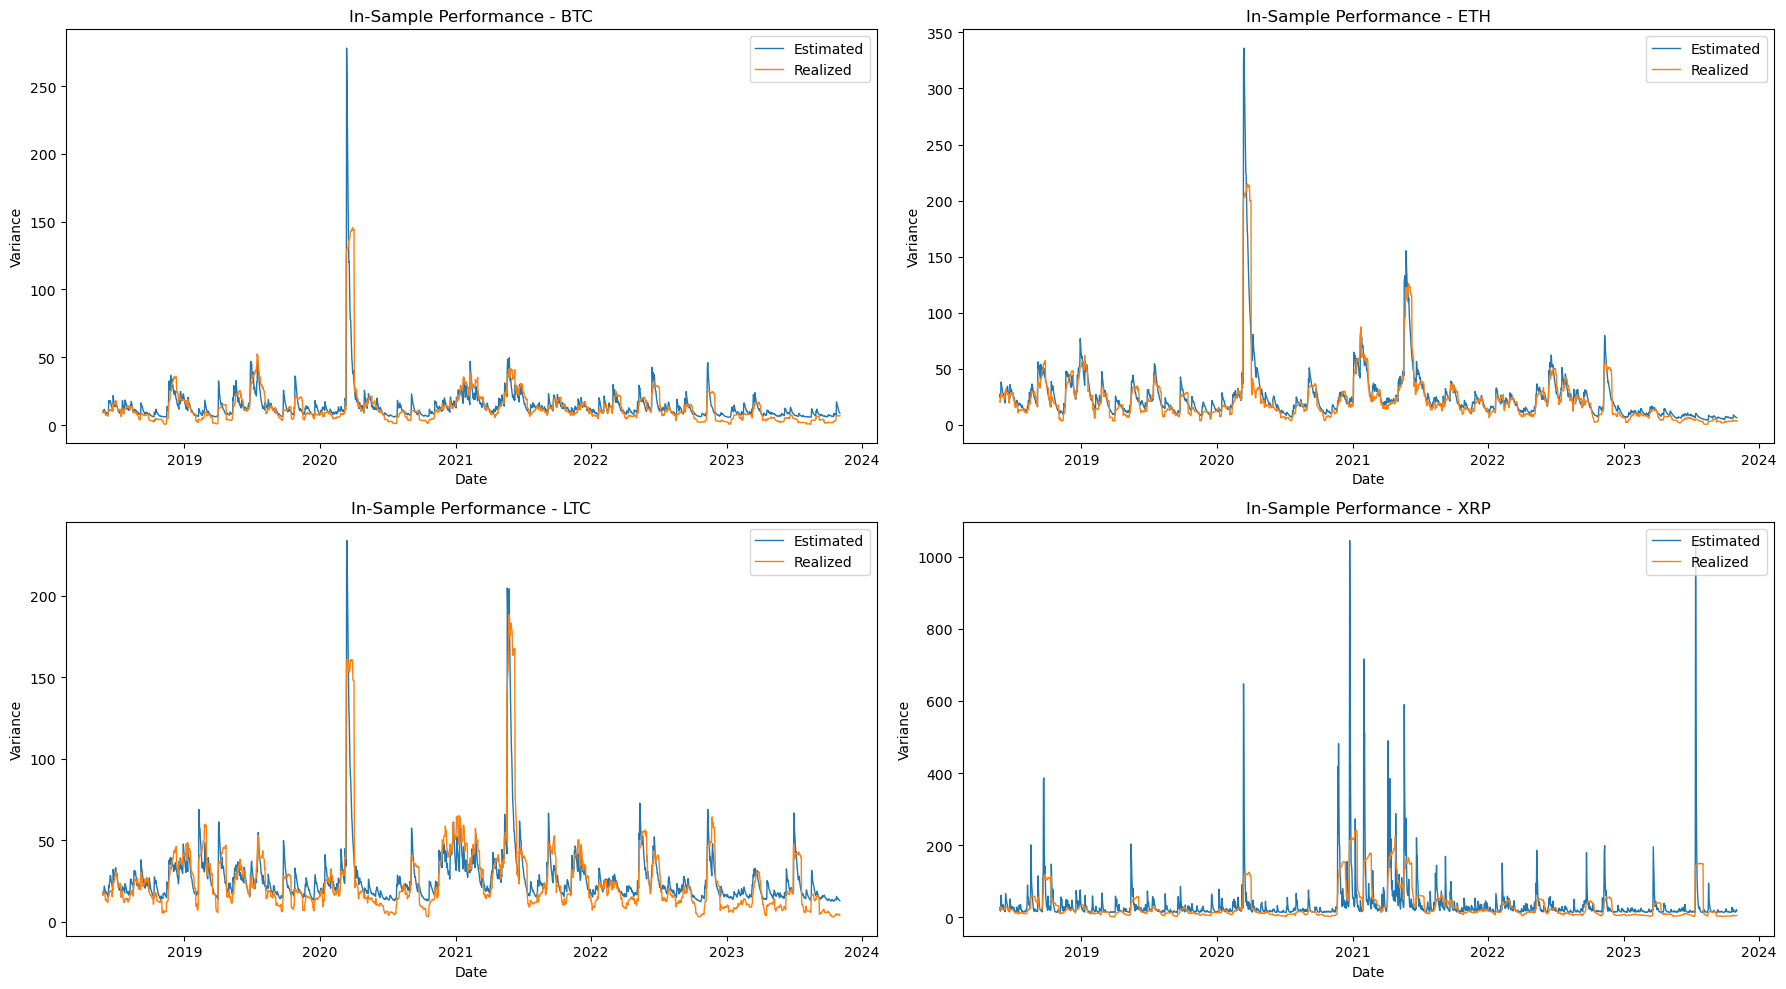

In [24]:
# in-sample visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, asset in enumerate(assets):
    axes[i].plot(conditional_vars.index, conditional_vars[asset], label='Estimated', linewidth=1)
    axes[i].plot(realized_vars_train.index, realized_vars_train[asset], label='Realized', linewidth=1)
    axes[i].set_title(f'In-Sample Performance - {asset}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Variance')
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [25]:
# check for heteroscedasticity
std_residuals_train = residuals_train / conditional_vols
ljungbox_results = []

for asset in assets:
    lb_test = acorr_ljungbox(std_residuals_train[asset]**2, lags=[10, 20, 30], return_df=True)
    for lag, row in lb_test.iterrows():
        ljungbox_results.append({
            'Asset': asset,
            'Lag': lag,
            'LB Statistic': row['lb_stat'],
            'P-Value': row['lb_pvalue'],
            'Heteroscedasticity': 'Yes' if row['lb_pvalue'] < 0.05 else 'No'
        })

ljungbox_results_df = pd.DataFrame(ljungbox_results)
ljungbox_results_df

,Asset,Lag,LB Statistic,P-Value,Heteroscedasticity
0,BTC,10,4.176602,0.939029,No
1,BTC,20,5.597675,0.999342,No
2,BTC,30,5.971423,0.999999,No
3,ETH,10,7.244417,0.702187,No
4,ETH,20,13.162877,0.870287,No
5,ETH,30,20.246218,0.909972,No
6,LTC,10,8.445295,0.585426,No
7,LTC,20,11.520644,0.931588,No
8,LTC,30,16.267866,0.980360,No
9,XRP,10,0.776120,0.999947,No


In [26]:
# out-of-sample forecasting
predicted_vars_1 = pd.DataFrame(index=residuals_test.index)
predicted_vars_5 = pd.DataFrame(index=residuals_test.index)
predicted_vars_22 = pd.DataFrame(index=residuals_test.index)
window = 1000

for asset in assets:
    garch_forecasts_1 = []
    garch_forecasts_5 = []
    garch_forecasts_22 = []
    print(f'Forecasting 1/5/22-day ahead residual variances for {asset} ...')

    for t in range(len(residuals_test)):
        residuals_train_subset = residuals.iloc[split_idx + t - window:split_idx + t][asset]
        model = arch_model(residuals_train_subset, vol='GARCH', p=1, q=1, mean='Zero', dist='normal')
        result = model.fit(disp=False)

        forecast_1 = result.forecast(horizon=22).residual_variance.iloc[-1, 0]
        forecast_5 = result.forecast(horizon=22).residual_variance.iloc[-1, 4]
        forecast_22 = result.forecast(horizon=22).residual_variance.iloc[-1, 21]

        garch_forecasts_1.append(forecast_1)
        garch_forecasts_5.append(forecast_5)
        garch_forecasts_22.append(forecast_22)
    
    predicted_vars_1[asset] = garch_forecasts_1
    predicted_vars_5[asset] = garch_forecasts_5
    predicted_vars_22[asset] = garch_forecasts_22

predicted_vars_5 = predicted_vars_5.shift(4).dropna()
predicted_vars_22 = predicted_vars_22.shift(21).dropna()

Forecasting 1/5/22-day ahead residual variances for BTC ...
Forecasting 1/5/22-day ahead residual variances for ETH ...
Forecasting 1/5/22-day ahead residual variances for LTC ...
Forecasting 1/5/22-day ahead residual variances for XRP ...


In [27]:
# out-of-sample evaluation
out_sample_results = []

for horizon, pred_vars in zip([1, 5, 22], [predicted_vars_1, predicted_vars_5, predicted_vars_22]):
    for asset in assets:
        pred_var = pred_vars[asset]
        rv = realized_vars_test[asset]
        rv = rv.loc[pred_var.index]

        print(f'Computing out-of-sample performance metrics for {asset} using {horizon}-day forecast ...')
        mse = ((rv - pred_var)**2).mean()
        mae = (rv - pred_var).abs().mean()
        hmse = ((1 - pred_var / rv)**2).mean()

        out_sample_results.append({
            'Model': 'GARCH',
            'Asset': asset,
            'Horizon': horizon,
            'MSE': mse,
            'MAE': mae,
            'HMSE': hmse
        })

out_sample_results_df = pd.DataFrame(out_sample_results)
out_sample_results_df

Computing out-of-sample performance metrics for BTC using 1-day forecast ...
Computing out-of-sample performance metrics for ETH using 1-day forecast ...
Computing out-of-sample performance metrics for LTC using 1-day forecast ...
Computing out-of-sample performance metrics for XRP using 1-day forecast ...
Computing out-of-sample performance metrics for BTC using 5-day forecast ...
Computing out-of-sample performance metrics for ETH using 5-day forecast ...
Computing out-of-sample performance metrics for LTC using 5-day forecast ...
Computing out-of-sample performance metrics for XRP using 5-day forecast ...
Computing out-of-sample performance metrics for BTC using 22-day forecast ...
Computing out-of-sample performance metrics for ETH using 22-day forecast ...
Computing out-of-sample performance metrics for LTC using 22-day forecast ...
Computing out-of-sample performance metrics for XRP using 22-day forecast ...


,Model,Asset,Horizon,MSE,MAE,HMSE
0,GARCH,BTC,1,10.990224,2.474809,0.335851
1,GARCH,ETH,1,15.409716,2.831137,0.144538
2,GARCH,LTC,1,44.184943,5.462490,0.586496
3,GARCH,XRP,1,342.420020,12.968591,3.164914
4,GARCH,BTC,5,10.088138,2.695240,0.544219
5,GARCH,ETH,5,16.110181,3.079073,0.209690
6,GARCH,LTC,5,61.477140,6.495584,1.046520
7,GARCH,XRP,5,430.875924,14.768661,5.196506
8,GARCH,BTC,22,17.215806,3.685502,0.993256
9,GARCH,ETH,22,51.949646,5.549651,0.921010


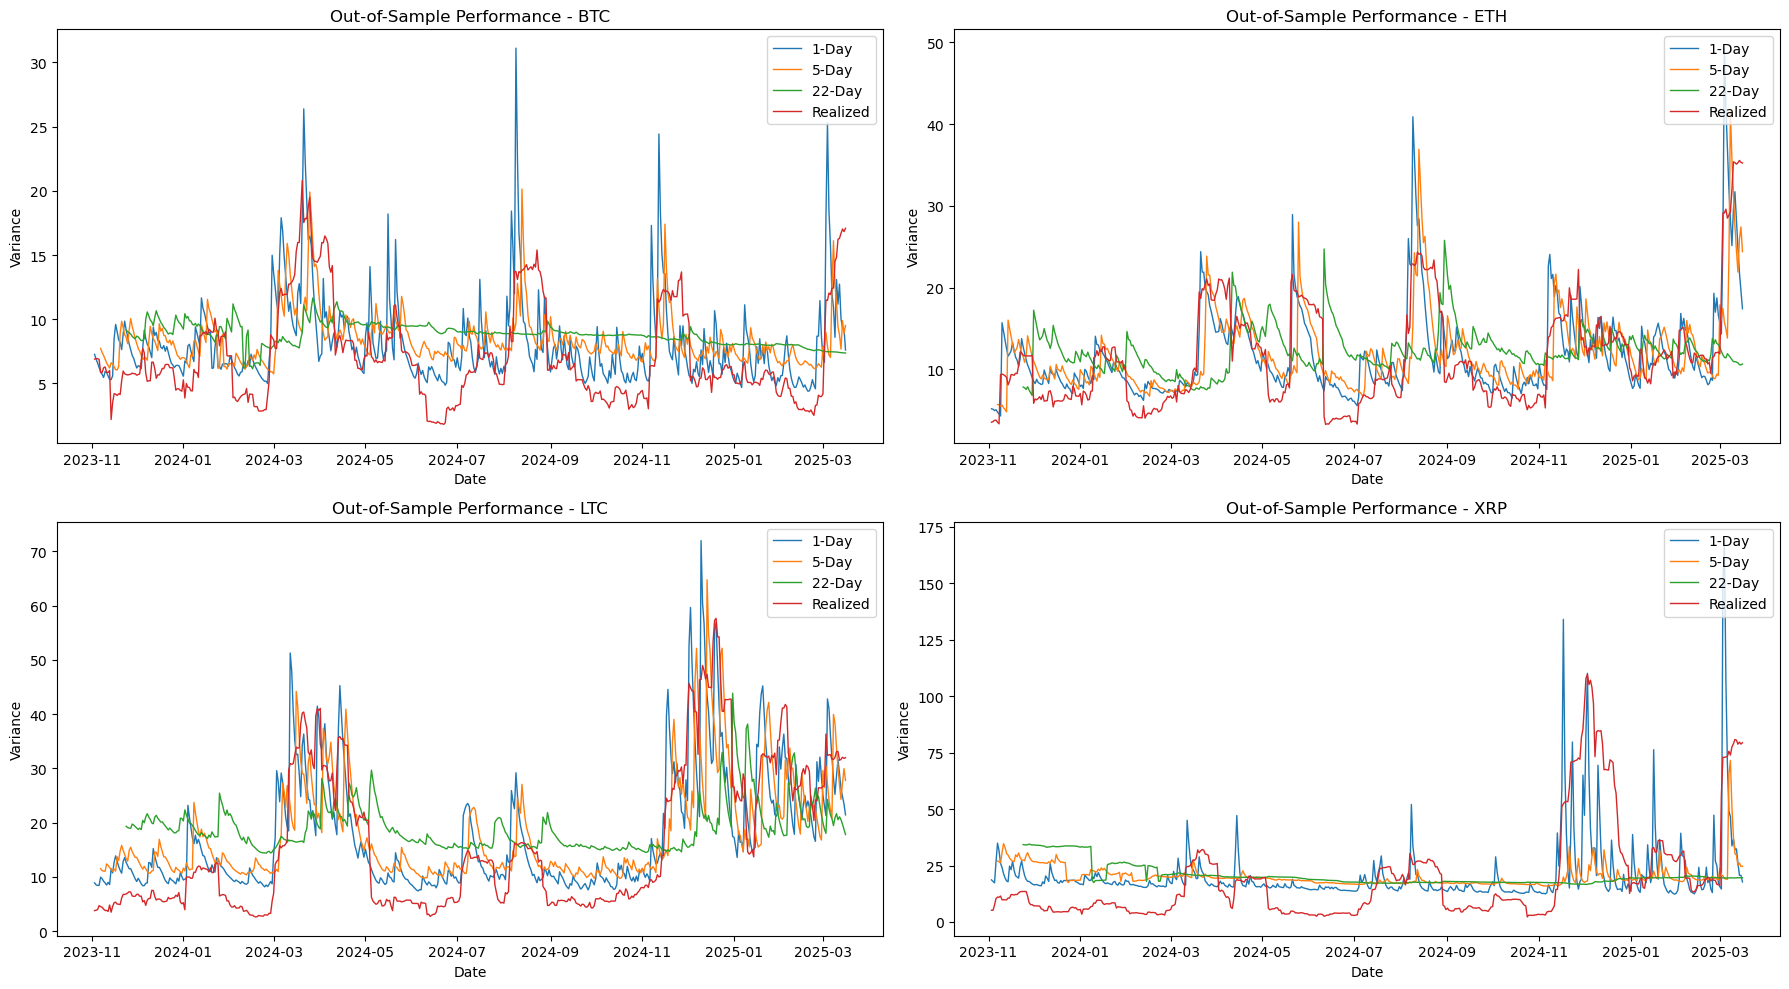

In [28]:
# out-of-sample visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, asset in enumerate(assets):
    axes[i].plot(predicted_vars_1.index, predicted_vars_1[asset], label='1-Day', linewidth=1)
    axes[i].plot(predicted_vars_5.index, predicted_vars_5[asset], label='5-Day', linewidth=1)
    axes[i].plot(predicted_vars_22.index, predicted_vars_22[asset], label='22-Day', linewidth=1)
    axes[i].plot(realized_vars_test.index, realized_vars_test[asset], label='Realized', linewidth=1)
    axes[i].set_title(f'Out-of-Sample Performance - {asset}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Variance')
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()